## Tutorial: Encoding Quantum Circuits as Graphs and Training a GNN on an Example Dataset

This tutorial shows:
- How quantum circuits are encoded into graph data used by the GNN in this repo
- How to load the Random dataset (`gnn/data/dataset_random`) of circuits
- How to train and evaluate the GNN on that dataset

You will learn about the node embedding, global feature set, and dataset preparation.

Prerequisites:
- Python 3.10+
- PyTorch and PyTorch Geometric (install instructions below)
- Qiskit for parsing QASM
- This repository cloned locally


In [14]:
# I have added this for avoiding warnings coming from running the code on my laptop. I always use the server with gpus for the GNN project. That's what I suggest for you as well.

import os, warnings

os.environ['PYTHONWARNINGS'] = (
    "ignore:::torch_geometric.typing,"
    "ignore:An issue occurred while importing 'pyg-lib'.*:UserWarning,"
    "ignore:An issue occurred while importing 'torch-sparse'.*:UserWarning"
)
warnings.filterwarnings("ignore", category=UserWarning, module=r"torch_geometric\.typing")
warnings.filterwarnings("ignore", message=r"An issue occurred while importing 'pyg-lib'.*", category=UserWarning)
warnings.filterwarnings("ignore", message=r"An issue occurred while importing 'torch-sparse'.*", category=UserWarning)

In [9]:
from pathlib import Path
import os
import sys

# Ensure project root is on path (works in notebooks where __file__ may be undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    PROJECT_ROOT = Path(os.getcwd()).resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Absolute path to the Random dataset folder in this repo
RANDOM_BASE_DIR = "/Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random"

# Core imports used in this tutorial
from gnn.gnn import (
    train_with_two_stage_split,
    evaluate_overall_mse,
    evaluate_overall_r2,
)
from gnn.gnn_run import select_random_pkls
from gnn.graph_representation import qasm_to_pyg_graph, get_global_feature_dim, get_node_feature_dim

import torch
print(f"Torch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

# Sanity check dataset directory
assert os.path.isdir(RANDOM_BASE_DIR), f"Dataset dir not found: {RANDOM_BASE_DIR}"
print(f"Random dataset base: {RANDOM_BASE_DIR}")


Torch: 2.3.1, CUDA: False
Random dataset base: /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random


### How circuits are encoded as graphs

The module `gnn/graph_representation.py` converts each circuit QASM into a PyTorch Geometric `Data` object:
- **Nodes**: inputs (one per qubit), gate nodes (e.g., `rx`, `ry`, `rz`, `cx`), and measurement/output nodes (one per qubit).
- **Edges**: directed along the time flow on each wire; multi-qubit gates receive incoming edges from all involved wires.
- **Node features**: concatenation of
  - One-hot gate type over a gate vocabulary
  - A fixed-length qubit mask (which qubits the node touches)
  - Optional backend-specific features (+7 dims per node if enabled)
- **Global features**: one vector per circuit, variant-dependent:
  - `baseline` (8 dims): depth, param-gate count, num qubits, total gates, and counts for `rx/ry/rz/cx`.
  - `binned152` (152 dims): 50 bins each for `rx/ry/rz` angles, plus counts of `h` and `cx`.
  - `oslo` (53 dims): 50 bins for `rz` angles, plus counts for `sx/x/ecr`.

The GNN consumes node features and pools across nodes, concatenating with a learned embedding of the global features before regression.


Node feature matrix shape: (10, 33)
Edge index shape: (2, 8)
Global features shape: (152,)
Gate counts: {'rx': 1, 'ry': 1, 'rz': 1, 'cx': 1, 'h': 0}


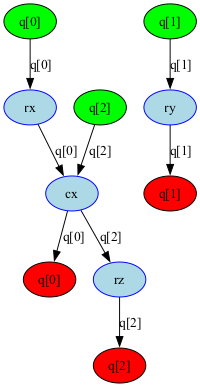

First 10 global features (binned variant): [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
# Encode a tiny example circuit to inspect features
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag

from qiskit.visualization import dag_drawer

from IPython.display import display, Image as IPyImage
from io import BytesIO

qasm = (
    "OPENQASM 2.0;\n"
    "include \"qelib1.inc\";\n"
    "qreg q[3];\n"
    "rx(0.5) q[0];\n"
    "ry(1.2) q[1];\n"
    "cx q[0],q[2];\n"
    "rz(2.2) q[2];\n"
)

# Use the same defaults as training: global_feature_variant="binned152"
data, gate_counts = qasm_to_pyg_graph(qasm, global_feature_variant="binned152")
print("Node feature matrix shape:", tuple(data.x.shape))
print("Edge index shape:", tuple(data.edge_index.shape))
print("Global features shape:", tuple(data.global_features.shape))
print("Gate counts:", gate_counts)

# Show the DAG representation of the quantum circuit
qc = QuantumCircuit.from_qasm_str(qasm)
dag = circuit_to_dag(qc)

img = dag_drawer(dag)
try:
    # Normalize for notebook display
    from PIL import Image as PILImage  # type: ignore
    if isinstance(img, PILImage.Image) and img.mode == 'RGBA':
        img = img.convert('RGB')
    display(img)
except Exception:
    # Fallback to PNG bytes
    try:
        bio = BytesIO()
        img.save(bio, format='PNG')
        display(IPyImage(data=bio.getvalue(), format='png'))
    except Exception:
        fig = qc.draw(output="mpl")
        display(fig)


# Inspect the first few global feature entries
print("First 10 global features (binned variant):", data.global_features[:10].tolist())


### Load the Random dataset

The Random dataset contains PKL shards under `gnn/data/dataset_random`, named like:
- `basis_rotations+cx_qubits_{Q}_gates_{START}-{END}.pkl`

We can select a subset by qubit count and gate-count range using `select_random_pkls`. For a quick run, start with a smaller gate range.


In [11]:
# Select PKL files from the Random dataset
# Qubits to include (dataset has 2..6)
qubits = [2, 3, 4, 5, 6]

# Use a smaller gate range to make the tutorial quick to run
use_small_subset = True
if use_small_subset:
    gates_range = (None, 39)  # include shards with gates 0-19, 20-39
else:
    gates_range = (None, 99)  # include up to 99 gates

pkl_paths = select_random_pkls(
    base_dir=RANDOM_BASE_DIR,
    qubits=qubits,
    gates=None,
    gates_range=gates_range,
)

print(f"Selected PKL files: {len(pkl_paths)}")
for p in pkl_paths[:8]:
    print(" -", p)
if len(pkl_paths) > 8:
    print(" ...")


Selected PKL files: 10
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_2_gates_0-19.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_2_gates_20-39.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_3_gates_0-19.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_3_gates_20-39.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_4_gates_0-19.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_4_gates_20-39.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_5_gates_0-19.pkl
 - /Users/vlipardi/Documents/Github/Magic-Informed_QAS/gnn/data/dataset_random/basis_rotations+cx_qubits_5_gates_20-39.p

### Train the GNN on the Random dataset

We use `train_with_two_stage_split`, which internally:
- Builds train/val/test loaders with a two-stage split
- Instantiates `CircuitGNN` with feature dimensions matching our chosen variants
- Trains with early stopping

Defaults here use `global_feature_variant='binned152'` and no backend node features.


In [12]:
# Train configuration (keep small for tutorial runtime)
EPOCHS = 15
LR = 1e-3
BATCH_SIZE = 64
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.0
TRAIN_SPLIT = 0.8
VAL_WITHIN_TRAIN = 0.1
SEED = 42

GLOBAL_FEATURE_VARIANT = "binned152"  
NODE_FEATURE_BACKEND_VARIANT = None    # set to "fake_oslo" to add backend features

model, train_loader, val_loader, test_loader, device = train_with_two_stage_split(
    pkl_paths=pkl_paths,
    epochs=EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    device=None,  # auto-select
    global_feature_variant=GLOBAL_FEATURE_VARIANT,
    node_feature_backend_variant=NODE_FEATURE_BACKEND_VARIANT,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    early_stopping_min_delta=EARLY_STOPPING_MIN_DELTA,
    train_split=TRAIN_SPLIT,
    val_within_train=VAL_WITHIN_TRAIN,
    model_kwargs={
        # Examples hyperparameter for "fast" run
        "gnn_hidden": 32,
        "gnn_heads": 2,
        "global_hidden": 64,
        "reg_hidden": 128,
        "num_layers": 3,
    },
    seed=SEED,
    loss_type="huber",
)

print("Device:", device)
print("Train graphs:", len(train_loader.dataset))
print("Val graphs:", len(val_loader.dataset))
print("Test graphs:", len(test_loader.dataset))


Processing...
Done!


Epoch 001 | TrainLoss 0.0303 | ValLoss 0.0213
Epoch 002 | TrainLoss 0.0229 | ValLoss 0.0203
Epoch 003 | TrainLoss 0.0215 | ValLoss 0.0189
Epoch 004 | TrainLoss 0.0205 | ValLoss 0.0212
Epoch 005 | TrainLoss 0.0200 | ValLoss 0.0200
Epoch 006 | TrainLoss 0.0195 | ValLoss 0.0181
Epoch 007 | TrainLoss 0.0189 | ValLoss 0.0178
Epoch 008 | TrainLoss 0.0187 | ValLoss 0.0198
Epoch 009 | TrainLoss 0.0182 | ValLoss 0.0183
Epoch 010 | TrainLoss 0.0180 | ValLoss 0.0188
Epoch 011 | TrainLoss 0.0179 | ValLoss 0.0185
Epoch 012 | TrainLoss 0.0176 | ValLoss 0.0182
Epoch 013 | TrainLoss 0.0173 | ValLoss 0.0188
Epoch 014 | TrainLoss 0.0172 | ValLoss 0.0189
Epoch 015 | TrainLoss 0.0170 | ValLoss 0.0192
Device: cpu
Train graphs: 72000
Val graphs: 8000
Test graphs: 20000


Train MSE: 0.033251  |  R2: 0.8304
Val   MSE: 0.035544  |  R2: 0.8200
Test  MSE: 0.036645  |  R2: 0.8125


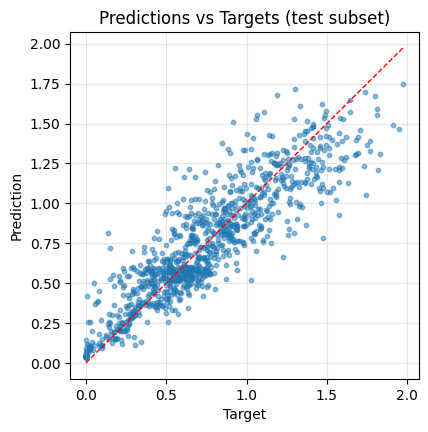

In [13]:
# Evaluate on train/test
train_mse = evaluate_overall_mse(model, train_loader, device)
val_mse = evaluate_overall_mse(model, val_loader, device)
test_mse = evaluate_overall_mse(model, test_loader, device)

train_r2 = evaluate_overall_r2(model, train_loader, device)
val_r2 = evaluate_overall_r2(model, val_loader, device)
test_r2 = evaluate_overall_r2(model, test_loader, device)

print(f"Train MSE: {train_mse:.6f}  |  R2: {train_r2:.4f}")
print(f"Val   MSE: {val_mse:.6f}  |  R2: {val_r2:.4f}")
print(f"Test  MSE: {test_mse:.6f}  |  R2: {test_r2:.4f}")

# Optional: scatter plot predictions vs targets on a test batch
import math
import matplotlib.pyplot as plt
model.eval()
x_vals, y_vals = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        yhat = model(batch).detach().cpu()
        y = batch.y.view(-1).detach().cpu()
        mask = torch.isfinite(y)
        x_vals.extend(y[mask].tolist())
        y_vals.extend(yhat[mask].tolist())
        if len(x_vals) > 1000:  # cap points for plotting
            break

if x_vals:
    plt.figure(figsize=(4.5, 4.5))
    plt.scatter(x_vals, y_vals, s=10, alpha=0.5)
    mn = min(min(x_vals), min(y_vals))
    mx = max(max(x_vals), max(y_vals))
    plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title("Predictions vs Targets (test subset)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No finite labels available for scatter plot.")


### Tips and troubleshooting

- **Dataset cache**: When first loading PKLs, graphs are processed and cached under a directory like `pyg_cache_*/processed`. This avoids reprocessing on reruns. The cache key includes feature dimensions.
- **Use the full dataset**: Set `use_small_subset = False` to include all shards up to 99 gates. Training will take longer and use more memory.
- **GPU acceleration**: If CUDA is available, training will automatically use it. Check the device printout.
- **Feature variants**: You can switch `GLOBAL_FEATURE_VARIANT` to `"oslo"`which incorporates the specifics of the IBM Quantum backend FakeOslo. If you enable backend node features (e.g., `NODE_FEATURE_BACKEND_VARIANT = "fake_oslo"`), the dataset will be reprocessed with the extra 7 node feature dims.
- **Hyperparameters**: For larger runs, consider increasing `num_layers`, `gnn_hidden`, or running the provided grid search utilities in `gnn/gnn_run.py`.
- **PKL structure**: Each PKL holds items of the form `({"qasm": str, "num_qubits": int}, label: float)` or unlabeled dicts; only labeled entries are used for supervised training.
